In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_all_locations
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Torch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable


sns.set_theme(style="darkgrid")

In [3]:
data = load_all_locations()

In [4]:
def create_time_features(df):
    df['hour'] = df.time.dt.hour
    df['dayofmonth'] = df.time.dt.day
    df['dayofweek'] = df.time.dt.dayofweek
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    return df

In [5]:
X, y = data[0].copy(), data[1].copy()


# One-hot Encoding
X = X.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X["location"]).astype(int)
X = X.drop("location", axis=1)
X = pd.merge(X, one_hot, left_index=True, right_index=True)

# Add time based features
X = create_time_features(X)

# Drop datetime
X = X.drop(columns=["time"])

# Drop missing column values
nan_columns = X.columns[X.isna().any()].tolist()
X = X.drop(columns=nan_columns)

X.shape, y.shape


((81118, 53), (81118, 4))

In [6]:
X_train = X[X.set_type == "TRAIN"].copy().drop(columns=["set_type"])
X_train_scaler = MinMaxScaler()
X_train_scaler = X_train_scaler.fit(X_train)
X_train = X_train_scaler.transform(X_train)

y_train = y[y.set_type == "TRAIN"].copy()[["y"]]
y_train_scaler = MinMaxScaler()
y_train_scaler = y_train_scaler.fit(y_train)
y_train = y_train_scaler.transform(y_train)

X_test = X[(X.set_type == "TEST")].copy().drop(columns=["set_type"])
y_test = y[(y.set_type == "TEST")].copy()[["y"]]
# X_test = X[(X.set_type == "TEST") & (X.A == True)].copy().drop(columns=["set_type"])
# y_test = y[(y.set_type == "TEST") & (y.location == "A")].copy()[["y"]]

X_test = X_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)


In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [8]:
# Instantiating Model Class
input_dim = 52
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.L1Loss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters())

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [9]:
X_test.shape[1]

52

In [11]:
# Training the model
seq_dim = 1

n_iter = 0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 50
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)

        train_loss.append(loss.data)
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
        n_iter += 1  
            
        if n_iter%100 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.mean(np.abs(Kt_test.data.numpy() - outputs.data.numpy().squeeze()))
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data, mse))

Epoch: 0 Iteration: 100. Train_MSE: 0.056731995195150375. Test_MSE: 0.041873570531606674
Epoch: 0 Iteration: 200. Train_MSE: 0.028853900730609894. Test_MSE: 0.03940415754914284
Epoch: 0 Iteration: 300. Train_MSE: 0.0008284401847049594. Test_MSE: 0.0458223894238472
Epoch: 0 Iteration: 400. Train_MSE: 0.01161998137831688. Test_MSE: 0.041602227836847305
Epoch: 0 Iteration: 500. Train_MSE: 0.0004988288856111467. Test_MSE: 0.04283464699983597
Epoch: 0 Iteration: 600. Train_MSE: 0.004203674383461475. Test_MSE: 0.04868488758802414
Epoch: 0 Iteration: 700. Train_MSE: 0.013500946573913097. Test_MSE: 0.0455872118473053
Epoch: 1 Iteration: 800. Train_MSE: 0.06896216422319412. Test_MSE: 0.03914617374539375
Epoch: 1 Iteration: 900. Train_MSE: 0.05789221450686455. Test_MSE: 0.03729189187288284
Epoch: 1 Iteration: 1000. Train_MSE: 0.000996443210169673. Test_MSE: 0.04261096939444542
Epoch: 1 Iteration: 1100. Train_MSE: 0.010414081625640392. Test_MSE: 0.04153499752283096
Epoch: 1 Iteration: 1200. Train

In [ ]:
features.shape

torch.Size([100, 1, 52])

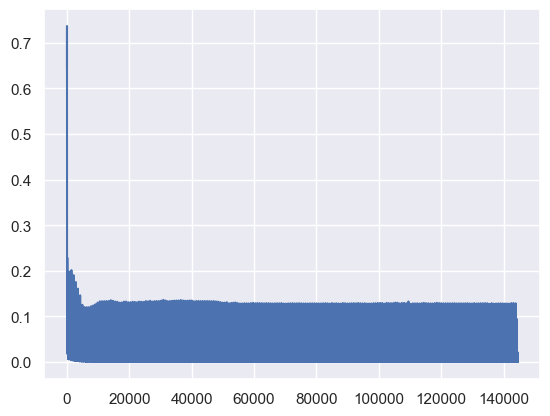

In [12]:
plt.plot(train_loss,'-')

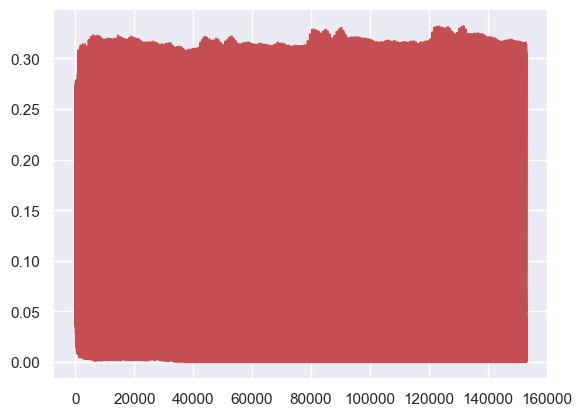

In [13]:
plt.plot(test_loss,'r')

In [24]:
model

RNNModel(
  (rnn): RNN(52, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

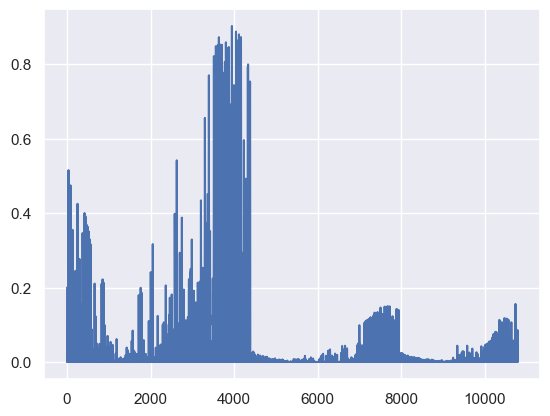

In [25]:
plt.plot(y_test)
plt.plot(model(X_test))

In [16]:
input = X_train.copy()

AttributeError: 'Tensor' object has no attribute 'copy'

In [19]:
predictions = np.array([])

for i in range(0, int(num_samples/batch_size -1)):
    features = Variable(torch.from_numpy(X_test).type(torch.FloatTensor)[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)

    predictions = np.append(predictions, model(features).detach().numpy())

TypeError: expected np.ndarray (got Tensor)

In [18]:
preds = y_train_scaler.inverse_transform(predictions.reshape(1, -1))

ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

NameError: name 'preds' is not defined

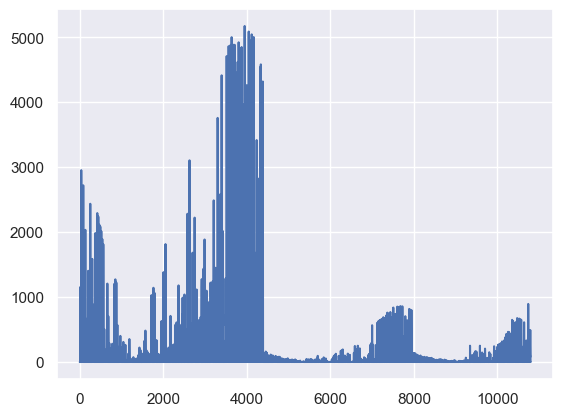

In [17]:
plt.plot(y_train_scaler.inverse_transform(y_test))
plt.plot(list(preds[0]))

In [ ]:
y_test.shape

(10795, 1)

In [ ]:
preds.T.shape

(10795, 1)

In [ ]:
print(
    "MAE: ",
    round(
        mean_absolute_error(
            y_true=y_train_scaler.inverse_transform(y_test),
            y_pred=preds.T,
        ),
        3,
    ),
)

MAE:  152.992
